In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymongo
import pickle


%matplotlib inline

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [13]:
%run ../scripts/equations.py

In [14]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [7]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [8]:
desc_children = pd.Series({doc["uid"]:db.medline.descs.distinct("uid",{"ancestors":{"$in":doc["tn"]}})
               for doc in db.medline.descs.find({"uid":{"$in":bc_uids}})})
desc_children_count = desc_children.apply(len)

In [10]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [183]:
bc_results = {}
bc_results_gt0 = {}
for tup in desc_children.iteritems():
    bc_results_gt0[tup[0]] = set(gene_uid[(gene_uid.uid.isin(tup[1] + [tup[0]])) & (gene_uid.npmi>0.0)].gene_id)
    bc_results[tup[0]] = set(gene_uid[(gene_uid.uid.isin(tup[1] + [tup[0]]))].gene_id)
    print(tup[0])
bc_results = pd.Series(bc_results)
bc_results_gt0 = pd.Series(bc_results_gt0)

D001940
D001941
D002453
D002470
D004249
D004260
D007107
D007249
D009389
D012739
D013006
D015262
D017209
D018384
D018919
D049109
D057890


In [184]:
data = pd.DataFrame([bc_results.apply(len),
                     bc_results_gt0.apply(len),
                     desc_children_count],index=["no npmi cutoff",
                                                 "npmi>0.0",
                                                 "number of descendants"]).T
data["name"] = data.index.to_series().map(desc_name_map)

In [185]:
data = data.sort_values(["number of descendants","no npmi cutoff","npmi>0.0"],ascending=False)

In [186]:
data.set_index("name",inplace=True)

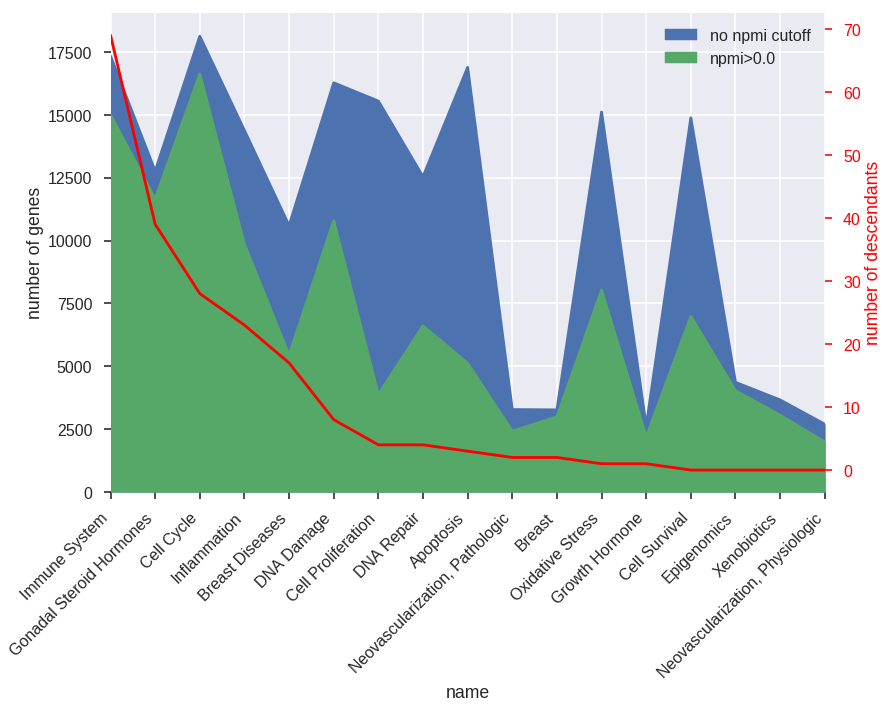

In [187]:
sns.set_context("poster")
sns.set_style("darkgrid")

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

data[["no npmi cutoff","npmi>0.0"]].plot(kind="area",
                                         ax=ax1,
                                         xticks=list(range(len(data.index.values))),
                                         stacked=False,
                                         alpha=1
#                                          position=0.5
                                        )

data["number of descendants"].plot(ax=ax2,color="r",grid=False)

ax1.tick_params(axis="both",size=7)
ax1.set_ylabel("number of genes")
ax2.tick_params(axis="y",size=7,colors="red")
ax2.set_ylabel("number of descendants",color="red")

# plt.xlim(-0.25,len(data.index)-0.75)

for tick in ax1.xaxis.get_ticklabels():
    tick.set_horizontalalignment("right")
    tick.set_rotation(45)

In [188]:
sns.set_context("talk")
sns.set_style("white")

data.sort_values("number of children",ascending=False,inplace=True)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212,sharex=ax1)

ax3 = ax1.twinx()
ax4 = ax2.twinx()

data["total genes"].plot(ax=ax1,kind="bar")
data["number of children"].plot(ax=ax3,color="r")

data["ssi genes"].plot(ax=ax2,kind="bar")
data["number of children"].plot(ax=ax4,xlim=(-0.5,16.5),color="r")

ax1.set_ylabel("Total Number of\n Genes Retreived")
ax2.set_ylabel("Number of SSI\n Genes Retreived")
ax2.set_xlabel("MeSH Terms")

ax3.tick_params(axis="y",colors="red")
ax4.tick_params(axis="y",colors="red")

ax4.text(17.6, 120, "Number of Descendants",rotation=90)

for tick in ax2.xaxis.get_ticklabels():
    tick.set_horizontalalignment("right")
    tick.set_rotation(45)
    
ax1.tick_params(axis="y",length=7,top=False)
ax2.tick_params(axis="both",length=7,top=False)
ax3.tick_params(axis="y",length=7)
ax4.tick_params(axis="y",length=7)
fig.suptitle("Retreived Genes per to MeSH Term")
# plt.savefig("gene_child_cov.png",dpi=500,transparent=True,bbox_inches="tight")

KeyError: 'number of children'